## Fast and Accurate EMRI Waveforms Tutorial

Here we provide a set of examples for creating EMRI waveforms as a whole; looking at separate creation pieces (trajectory, amplitude, summation, etc.); and creating your own module to build directly into this framework. For details on the specifics of our waveforms like constructions used and generally methodology, we refer you to our papers [arxiv.org/2104.04582](https://arxiv.org/abs/2104.04582) and [arxiv.org/2008.06071](https://arxiv.org/abs/2008.06071) and the [package documentation](https://bhptoolkit.org/FastEMRIWaveforms/). 

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux, PN5

from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpSchwarzEcc

from few.utils.utility import ( 
    get_mismatch, 
    get_fundamental_frequencies, 
    get_separatrix, 
    get_mu_at_t, 
    get_p_at_t, 
    get_kerr_geo_constants_of_motion,
    ELQ_to_pex,
    )

from few.utils.mappings.pn import (
    xI_to_Y,
    Y_to_xI
)
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant, InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.summation.aakwave import AAKSummation
from few.utils.constants import *

from few.waveform import (
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)
from few.waveform.base import SphericalHarmonicWaveformBase, AAKWaveformBase, ABC

%matplotlib inline

## Full EMRI Waveforms in Schwarzschild Eccentric

In the section, we will describe how to create EMRI waveforms with our fast and slow Schwarzschild eccentric waveform models, which evolve eccentric flux-based trajectories in a Schwarzschild background. These models include [FastSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.FastSchwarzschildEccentricFlux) and [SlowSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.SlowSchwarzschildEccentricFlux). The fast model can be run exactly as shown here on CPUs or GPUs by providing the correct initialization arguments. 

The waveform model produces $h(t) = h_p - ih_c(t)$. It takes as arguments $\{M, \mu, p_0, e_0, \Phi_{\phi,0}, \Phi_{r, 0}\}$. $M$ is the larger mass (in $M_\odot$), $\mu$ is the compact object mass (in $M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity, and the final two are the initial phases in $\phi, r$.

### [FastSchwarzschildEccentricFlux](https://bhptoolkit.org/FastEMRIWaveforms/html/tutorial/FastEMRIWaveforms_tutorial.html#FastSchwarzschildEccentricFlux)

The fast waveform generates sparse trajectories with ~100 points. Amplitudes for all modes are then determined with ROMAN network. From these amplitudes, we perform mode selection to remove modes that do not contribute significantly to the waveform. The remaining modes and phases are then interpolated with cubic splines. In one final step, the amplitude, phase, and angular harmonic information is then combined with an interpolated summation. 

* Trajectory Module: [EMRIInspiral](https://bhptoolkit.org/FastEMRIWaveforms/html/user/traj.html#few.trajectory.inspiral.EMRIInspiral)

* Amplitude Module: [RomanAmplitude](https://bhptoolkit.org/FastEMRIWaveforms/html/user/amp.html#few.amplitude.romannet.RomanAmplitude)

* Summation Module: [InterpolatedModeSum](https://bhptoolkit.org/FastEMRIWaveforms/html/user/sum.html#few.summation.interpolatedmodesum.InterpolatedModeSum)

* Mode Selection: [ModeSelector](https://bhptoolkit.org/FastEMRIWaveforms/html/user/util.html#few.utils.modeselector.ModeSelector)

* Angular Harmonics: [GetYlms](https://bhptoolkit.org/FastEMRIWaveforms/html/user/util.html#few.utils.ylm.GetYlms)


In [2]:
use_gpu = False

# keyword arguments for inspiral generator (EMRIInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "buffer_length": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "buffer_length": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is available for this type of summation
    "pad_output": False,
}


few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [3]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dt = 10.0  # seconds
T = 1.0  # years

wave = few(M, mu, p0, e0, theta, phi, dt=dt, T=T)  #  defaults to dt = 10.0 for max T = 1.0 year

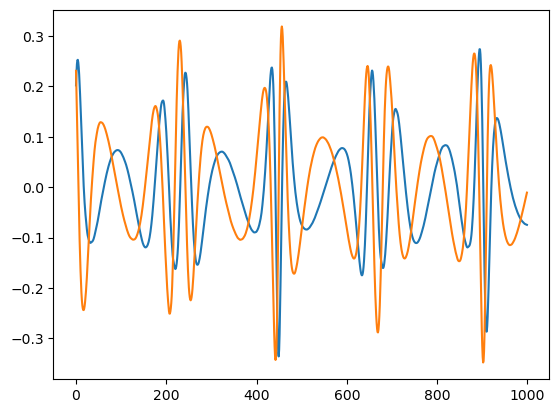

In [4]:
dt = 10.0
t = np.arange(len(wave)) * dt

plt.plot(wave.real[:1000])
plt.plot(wave.imag[:1000])

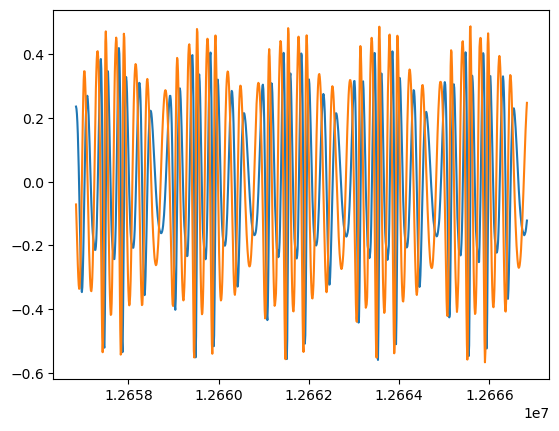

In [5]:
plt.plot(t[-1000:], wave.real[-1000:])
plt.plot(t[-1000:], wave.imag[-1000:])

To get shorter waveforms, you can provide the `T` kwarg for the function call. This is the observation time in years. You can also adjust `dt`. This is the sampling cadence of the waveform in seconds.

85300.0

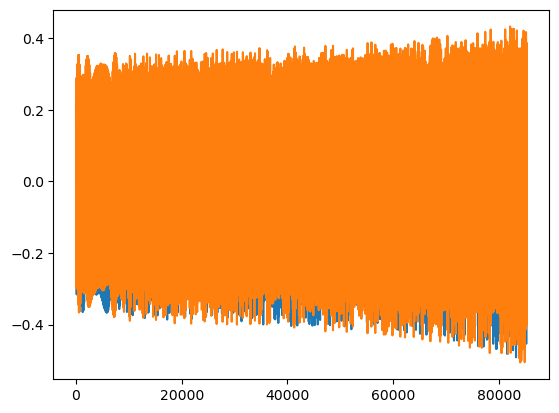

In [6]:
# parameters
M = 1e5
mu = 1e1
p0 = 8.0
e0 = 0.1
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle

dt = 10.0 # seconds
T = 0.1  # years
wave = few(M, mu, p0, e0, theta, phi, T=T, dt=dt)

t = np.arange(len(wave))*dt
plt.plot(t, wave.real)
plt.plot(t, wave.imag)

dt*(len(wave) - 1)

The `eps` kwarg will change the mode content of the waveform. Lowering it add modes. Increasing it will remove modes. The default is $10^{-5}$. This is generally recommended as good setting for good overlaps across the available parameter space.

wave1 used 455 modes. wave2 used 25 modes. The mismatch was 0.0014786836222281385


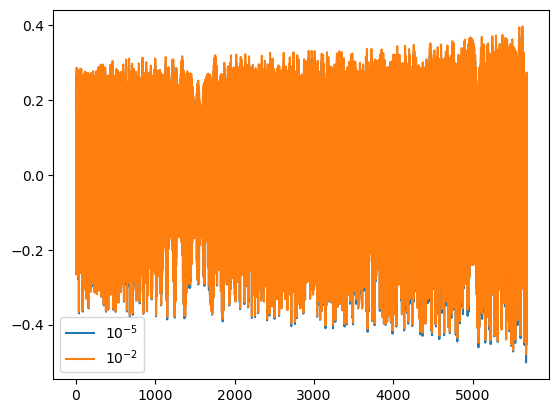

In [7]:
dt = 15.0 # seconds
T = 0.005  # years
wave1 = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, eps=1e-5)  # default

# we can check how many harmonic modes are kept
modes1 = few.num_modes_kept

wave2 = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, eps=1e-2)

modes2 = few.num_modes_kept

plt.plot(wave1.real, label=r'$10^{-5}$')
plt.plot(wave2.real, label=r'$10^{-2}$')
plt.legend()

# we can also compute the mismatch when removing modes
mm = get_mismatch(wave1, wave2)

# we can check how many modes were kept
print('wave1 used {} modes. wave2 used {} modes. The mismatch was {}'.format(modes1, modes2, mm))

### Waveform scaled by distance (generated in source frame)

The FastSchwarzschildEccentricFlux waveform is generated with source frame viewing angles. For all previous examples, the `dist` kwarg was left blank. To scale the waveform by the distance, you can add the distance in Gpc as a kwarg in the waveform generation class.

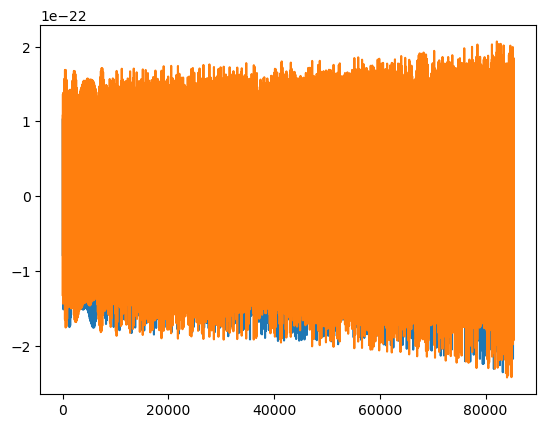

In [8]:
# parameters
M = 1e5
mu = 1e1
p0 = 8.0
e0 = 0.1
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dist = 1.0  # distance in Gpc

dt = 10.0 # seconds
T = 0.1  # years
wave = few(M, mu, p0, e0, theta, phi, dist=dist, T=T, dt=dt)

t = np.arange(len(wave))*dt
plt.plot(t, wave.real)
plt.plot(t, wave.imag)

### Producing waveforms with the generic interface

Waveforms can also be generated through a generic interface ([GenerateEMRIWaveform](https://bhptoolkit.org/FastEMRIWaveforms/html/user/main.html#few.waveform.GenerateEMRIWaveform)) where the specific waveform model is chosen with an argument. This can also be used to produce waveforms in the detector frame used for data analysis. This interface includes all EMRI parameters, including spin and inclination, as well as sky and orientation parameters. When a specific waveform model does not require certain parameters, the parameters will not affect the waveform generation. A detector-frame waveform in this case means $h_+,h_x$ in the SSB-frame. 

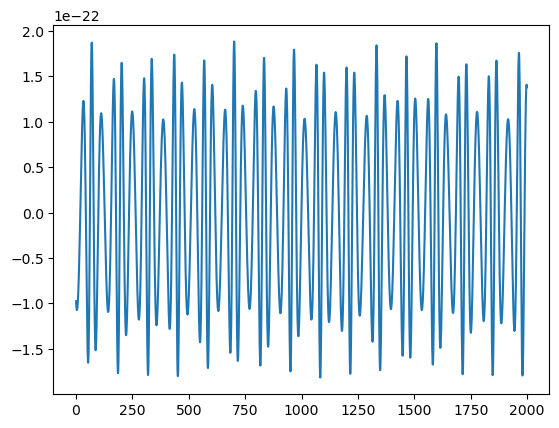

In [9]:
gen_wave = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux")

# parameters
T = 0.01  # years
dt = 15.0  # seconds
M = 1e6
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 1e1
p0 = 12.0
e0 = 0.2
x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(h.real[:2000])

### [SlowSchwarzschildEccentricFlux](https://bhptoolkit.org/FastEMRIWaveforms/html/user/main.html#few.waveform.SlowSchwarzschildEccentricFlux)

The slow waveform generates dense trajectories with at every `dt` seconds within `T` years. Amplitudes for all modes are then determined with a 2d bicubic spline over semi-latus rectum and eccentricity for each mode. This is done at each dense time step. We do not perform mode selection because this is the slow and most accurate model against which we compare the fast model. The final summation is a direct combination of phase, amplitude, and Ylm information at each dense timestep. 

**Note**: One thing to pay attention to with the slow waveform is batch size. This is determined by memory limits. Usually anything under ~10000 is fine.

* Trajectory Module: [EMRIInspiral](https://bhptoolkit.org/FastEMRIWaveforms/html/user/traj.html#few.trajectory.inspiral.EMRIInspiral)

* Amplitude Module: [AmpInterpSchwarzEcc](https://bhptoolkit.org/FastEMRIWaveforms/html/user/amp.html#few.amplitude.ampinterp2d.AmpInterpSchwarzEcc)

* Summation Module: [DirectModeSum](https://bhptoolkit.org/FastEMRIWaveforms/html/user/sum.html#few.summation.interpolatedmodesum.DirectModeSum)

* Mode Selection: None

* Angular Harmonics: [GetYlms](https://bhptoolkit.org/FastEMRIWaveforms/html/user/util.html#few.utils.ylm.GetYlms)


In [10]:
use_gpu = False

# keyword arguments for inspiral generator (EMRIInspiral)
inspiral_kwargs_dense={
        "DENSE_STEPPING": 1,  # we want a sparsely sampled trajectory
        "buffer_length": int(1e7),  # dense stepping trajectories
    }

# keyword arguments for inspiral generator (AmpInterpSchwarzEcc)
amplitude_kwargs = {
    "buffer_length": int(1e4),  # this must be >= batch_size
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (DirectModeSum)
sum_kwargs = {
}

slow = SlowSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs_dense,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

# parameters
T = 0.005  # years
dt = 15.0 # seconds
M = 1e6
mu = 1e1
p0 = 8.0
e0 = 0.2
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dist = 1.0  # distance in Gpc
batch_size = int(1e4)

slow_wave = slow(M, mu, p0, e0, theta, phi, dist=dist, T=T, dt=dt, batch_size=batch_size, mode_selection='all')

Length check: 10520 10520
Mismatch: 2.335984822310344e-05


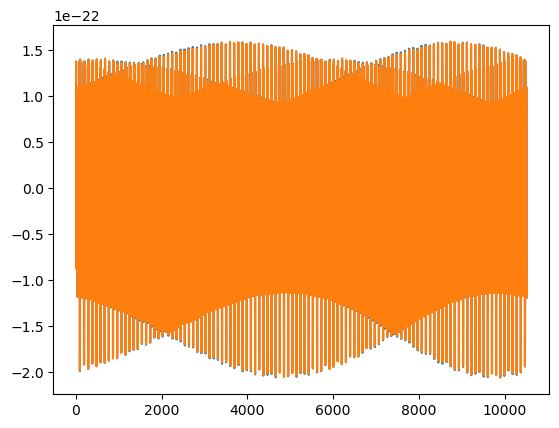

In [11]:
fast_wave = few(M, mu, p0, e0, theta, phi, dist=dist, T=T, dt=dt)

plt.plot(slow_wave.real)
plt.plot(fast_wave.real)
print('Length check:', len(fast_wave), len(slow_wave))
print('Mismatch:', get_mismatch(slow_wave, fast_wave))